In [70]:
# importing libraries
import datetime
import math
import matplotlib.pyplot as plt
import matplotlib.dates
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import scipy.signal as signal
import statsmodels.formula.api as smf

In [109]:
### Initial definitions and loading of datasets

# dataset file paths
data_path = './data/yt_metadata_en.jsonl.gz'
channels_path = './data/df_channels_en.tsv'
timeseries_path = './data/df_timeseries.tsv'
collaborators_path = './processed_data/dataframe_collaborations_videos.csv'
weekly_collaborators_path = './processed_data/collaborators_per_week.csv'

# Define the start and end dates of our study
start_date = pd.Timestamp('2016-01-01')
end_date = pd.Timestamp('2019-12-31')

### loading datasets and removing None 
df_channels = pd.read_csv(channels_path, sep ='\t').dropna()
df_timeseries = pd.read_csv(timeseries_path, sep ='\t').dropna()
df_collaborators = pd.read_csv(collaborators_path, sep=',').dropna()
df_weekly_collaborators = pd.read_csv(weekly_collaborators_path, sep=',')

# convert dates into datetime format
df_channels['join_date'] = pd.to_datetime(df_channels['join_date'])
df_timeseries['datetime'] = pd.to_datetime(df_timeseries['datetime'])

# only keep data within the dates of interest for our study
df_channels.drop(df_channels[df_channels.join_date > end_date].index, inplace=True)
df_timeseries.drop(df_timeseries[df_timeseries.datetime > end_date].index, inplace=True)
df_timeseries.drop(df_timeseries[df_timeseries.datetime < start_date].index, inplace=True)

# prepare channel id to channel name mapping dataset
channel_id_to_name = df_channels[['channel', 'name_cc']]

df_channels = df_channels[df_channels['category_cc']=='Gaming']
df_timeseries = df_timeseries[df_timeseries['category']=='Gaming']


In [131]:
# create channel id to channel name mapping set

channel_id_to_name_dict = channel_id_to_name.set_index('channel').T.to_dict('records')[0]


In [132]:
display(channel_id_to_name_dict)

{'UC-lHJZR3Gqxm24_Vd_AJ5Yw': 'PewDiePie',
 'UCbCmjCuTUZos6Inko4u57UQ': 'Cocomelon - Nursery ...',
 'UCpEhnqL0y41EpW2TvWAHD7Q': 'SET India',
 'UC295-Dw_tDNtZXFeAPAW6Aw': '5-Minute Crafts',
 'UCJ5v_MCY6GNUBTO8-D3XoAg': 'WWE',
 'UCIwFjwMjI0y7PDBVEO9-bkQ': 'Justin Bieber',
 'UCFFbwnve3yF62-tVXkTyHqg': 'Zee Music Company',
 'UCRijo3ddMTht_IHyNSNXpNQ': 'Dude Perfect',
 'UCk8GzjMOrta8yxDcKfylJYw': '✿ Kids Diana Show',
 'UC0C-w0YjGpqDXGB8IHb662A': 'Ed Sheeran',
 'UCEdvpU2pFRCVqU6yIPyTpMQ': 'Marshmello',
 'UCfM3zsQsOnfWNUppiycmBuw': 'EminemMusic',
 'UC9CoOnJkIBMdeijd9qYoT_g': 'Ariana Grande',
 'UCqECaJ8Gagnn7YCbPEzWH6g': 'Taylor Swift',
 'UCp0hYYBW6IMayGgR-WeoCvQ': 'TheEllenShow',
 'UCYvmuw-JtVrTZQ-7Y4kd63Q': 'Katy Perry',
 'UCcgqSM4YEo5vVQpqwN-MaNw': 'Rihanna',
 'UCvlE5gTbOvjiolFlEm-c_Ow': 'Vlad and Nikita',
 'UC3gNmTGu-TTbFPpfSs5kNkg': 'Movieclips',
 'UC4rlAVgAK0SGk-yTfe48Qpw': 'BRIGHT SIDE',
 'UCJrOtniJ0-NWz37R30urifQ': 'Alan Walker',
 'UCyoXW-Dse7fURq30EWl_CUA': 'Goldmines Telefilms',
 'UCB

# Research Question 4

What is happening **before** and **after** collaborations? Is the number of viewers increasing? Can collaborations prolong the life of a channel? 

### Relevant datasets 

To tackle the above research questions, we will consider the following metrics of a youtube channel: 
- growth trend in the number of views of the collaborating channels
- changes (increases/decreases) in the number of **subscribers** & **viewers** of collaborating channels 
- average rate of change of subscribers of collaborating channels (within the same period of time, regardless of whether there has been a collaboration)


In [72]:
# prepare collaborators dataset for sampling

collaborators = df_collaborators.dropna()['channel_id']

# take a sample of 10 channels
collaborators_sample = collaborators.sample(9)

# obtain timeseries dataset of the sample of collaborating channels
timeseries_collab_sample = df_timeseries[df_timeseries['channel'].isin(collaborators_sample)]


In [73]:
display(df_channels.columns)
display(df_collaborators.columns)
display(df_timeseries.columns)


Index(['category_cc', 'join_date', 'channel', 'name_cc', 'subscribers_cc',
       'videos_cc', 'subscriber_rank_sb', 'weights'],
      dtype='object')

Index(['categories', 'channel_id', 'crawl_date', 'dislike_count', 'display_id',
       'duration', 'like_count', 'upload_date', 'view_count',
       'final_collaborator_ids'],
      dtype='object')

Index(['channel', 'category', 'datetime', 'views', 'delta_views', 'subs',
       'delta_subs', 'videos', 'delta_videos', 'activity'],
      dtype='object')

In [74]:
timeseries_collab_sample.head(10)

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
1121942,UCTUHzVzRwN_2x13IWQ9QVNg,Gaming,2018-01-22 00:00:00,6792.000000,2318.000000,72.750000,0.000000,1,0,0
1121943,UCTUHzVzRwN_2x13IWQ9QVNg,Gaming,2018-01-29 00:00:00,14107.000000,7315.000000,142.300000,69.550000,1,0,0
1121944,UCTUHzVzRwN_2x13IWQ9QVNg,Gaming,2018-02-05 00:00:00,16634.000000,2527.000000,172.400000,30.100000,1,0,0
1121945,UCTUHzVzRwN_2x13IWQ9QVNg,Gaming,2018-02-12 00:00:00,18800.545455,2166.545455,198.272727,25.872727,1,0,0
1121946,UCTUHzVzRwN_2x13IWQ9QVNg,Gaming,2018-02-19 00:00:00,20824.090909,2023.545455,221.272727,23.000000,1,0,0
1121947,UCTUHzVzRwN_2x13IWQ9QVNg,Gaming,2018-02-26 00:00:00,22854.727273,2030.636364,237.181818,15.909091,1,0,0
1121948,UCTUHzVzRwN_2x13IWQ9QVNg,Gaming,2018-03-05 00:00:00,24406.333333,1551.606061,250.666667,13.484848,1,0,0
1121949,UCTUHzVzRwN_2x13IWQ9QVNg,Gaming,2018-03-12 00:00:00,25598.666667,1192.333333,262.333333,11.666667,1,0,0
1121950,UCTUHzVzRwN_2x13IWQ9QVNg,Gaming,2018-03-19 00:00:00,26476.596231,877.929565,271.558546,9.225213,1,0,0
1121951,UCTUHzVzRwN_2x13IWQ9QVNg,Gaming,2018-03-26 01:00:00,27302.125168,825.528937,280.376851,8.818304,1,0,0


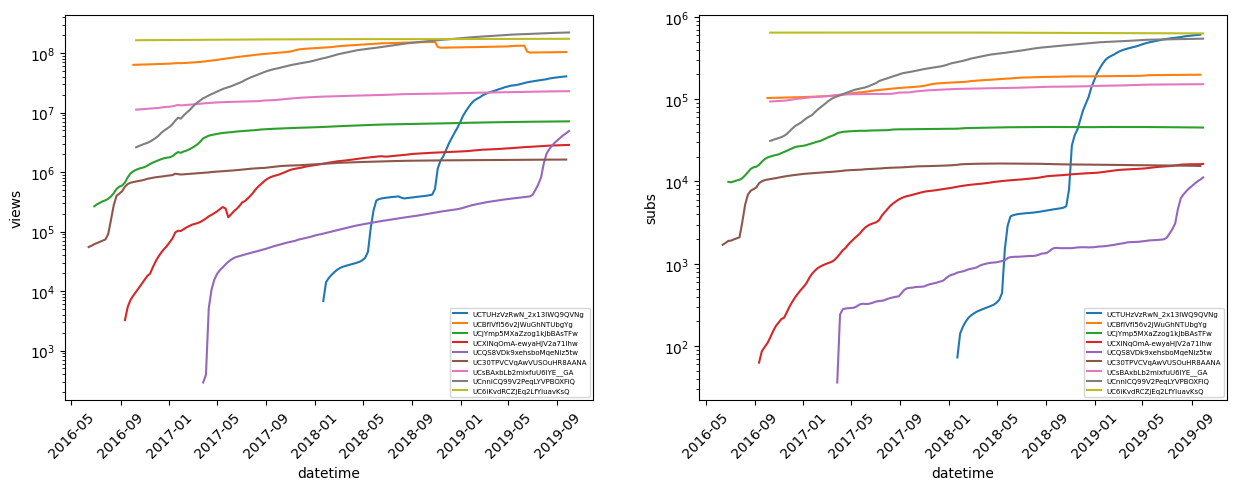

In [75]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 2, 1)

# plot timeseries of number of views a channel has
sns.lineplot(x = 'datetime', y = 'views', hue = 'channel', data = timeseries_collab_sample, ax=ax1)
ax1.set_yscale('log')
plt.xticks(rotation=45)
plt.legend(loc='lower right', fontsize = 5)

ax2 = fig.add_subplot(1, 2, 2)
# plot timeseries of number of subscribers a channel has
sns.lineplot(x = 'datetime', y = 'subs', hue = 'channel', data = timeseries_collab_sample, ax=ax2)
ax2.set_yscale('log')
plt.xticks(rotation=45)
plt.legend(loc='lower right', fontsize = 5)
plt.show()

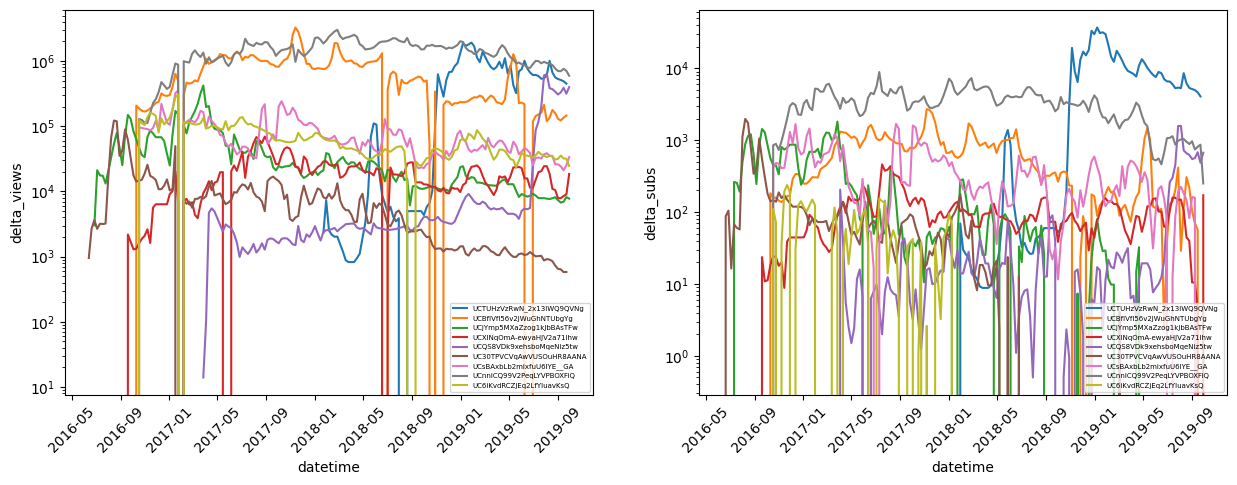

In [76]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 2, 1)

# plot timeseries of changes in number of views a channel has
sns.lineplot(x = 'datetime', y = 'delta_views', hue = 'channel', data = timeseries_collab_sample, ax=ax1)
ax1.set_yscale('log')
plt.xticks(rotation=45)
plt.legend(loc='lower right', fontsize = 5)

ax2 = fig.add_subplot(1, 2, 2)
# plot timeseries of changes in number of subscribers a channel has
sns.lineplot(x = 'datetime', y = 'delta_subs', hue = 'channel', data = timeseries_collab_sample, ax=ax2)
ax2.set_yscale('log')
plt.xticks(rotation=45)
plt.legend(loc='lower right', fontsize = 5)
plt.show()

## What is happening **before** and **after** collaborations?

We will first explore the impact of collaborations on a channel's views and subscriptions. 

In [137]:
# working with sample channels to visualise  trends

# take a sample channel
collab_example = collaborators.sample(1)

# obtain weekly collaboration data of sample channel
channel_collab_example = df_weekly_collaborators[df_weekly_collaborators['channel_id'].isin(collab_example)]

# add binary column for presence of collaborations in a particular week
channel_collab_example['is_collaborating'] = channel_collab_example['collaborators_in_week'].apply(lambda x: 0 if x is None or pd.isna(x) else 1)

# obtain timeseries data of the sample channel
timeseries_collab_example = df_timeseries[df_timeseries['channel'].isin(collab_example)]

array(['UCd2EmvcchaVjEykfuoH64Vw'], dtype=object)

/var/folders/1q/2jhpjh7924qd7d3drsy_79xw0000gn/T/ipykernel_5263/3333782861.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_collab_example['is_collaborating'] = channel_collab_example['collaborators_in_week'].apply(lambda x: 0 if x is None or pd.isna(x) else 1)


([], [])

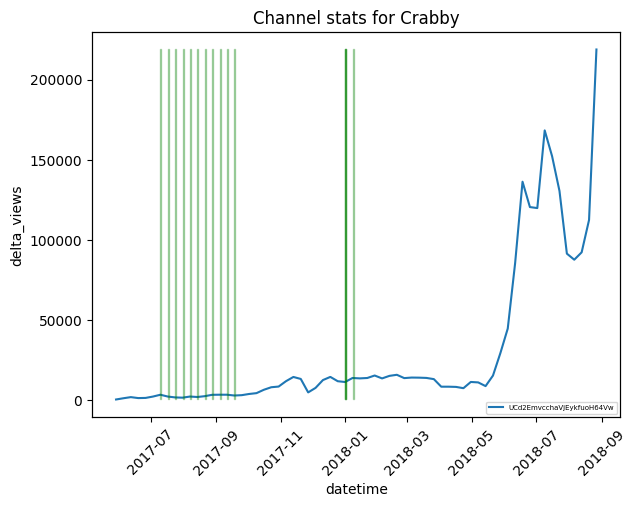

In [138]:
# plot graph of changes in views of the sample channel with collaboration data


# original_start_date = pd.Timestamp('2016-01-01')
# original_end_date = pd.Timestamp('2019-12-31')

sample_start_date = pd.Timestamp('2017-01-01')
sample_end_date = pd.Timestamp('2018-09-01')

dataset = timeseries_collab_example.drop(timeseries_collab_example[timeseries_collab_example.datetime < sample_start_date].index).copy()
dataset.drop(dataset[dataset.datetime > sample_end_date].index, inplace=True)

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 2, 1)

# plot timeseries of changes in number of views a channel has
sns.lineplot(x = 'datetime', y = 'delta_views', hue = 'channel', data = dataset, ax=ax1, color="blue")
plt.xticks(rotation=45)
plt.legend(loc='lower right', fontsize = 5)
ax1.set_title("Channel stats for " + channel_id_to_name_dict.get(collab_example.values[0]))

ax2 = ax1.twinx()

# plot collaboration binary timeline
# plot green for collaboration in the week
s1 = channel_collab_example[channel_collab_example['is_collaborating'] == 1]
data = channel_collab_example.copy()
data['datetime'] = data['Year-Week'].apply(lambda d: datetime.datetime.strptime(d + '-1', '%Y-%W-%w'))
data.drop(data[data.datetime > sample_end_date].index, inplace=True)
data.drop(data[data.datetime < sample_start_date].index, inplace=True)
inxval = matplotlib.dates.date2num(data[data['is_collaborating'] == 1]['datetime'])
times= list(zip(inxval, np.ones(len(s1))))
ax2.broken_barh(times, (0, 100), color="green", alpha = 0.3)
plt.yticks([])

/var/folders/1q/2jhpjh7924qd7d3drsy_79xw0000gn/T/ipykernel_5263/1328458080.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_collab_example_pewdiepie['is_collaborating'] = channel_collab_example_pewdiepie['collaborators_in_week'].apply(lambda x: 0 if x is None or pd.isna(x) else 1)


([], [])

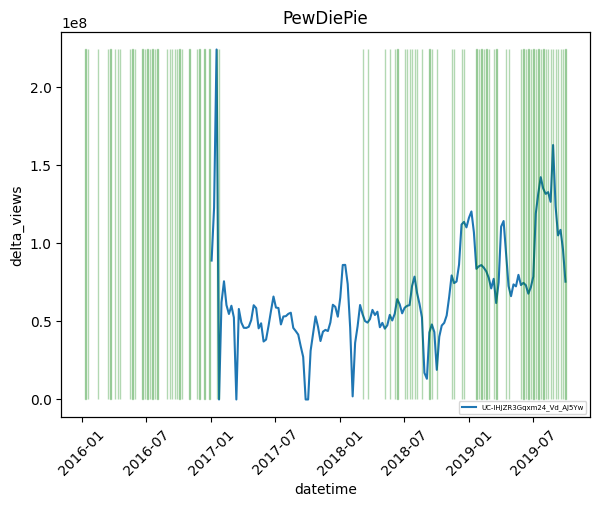

In [135]:
# plot graph of changes in views of PewDiePie's channel with collaboration data

# obtain weekly collaboration data of sample channel
channel_collab_example_pewdiepie = df_weekly_collaborators[df_weekly_collaborators['channel_id'].isin({'UC-lHJZR3Gqxm24_Vd_AJ5Yw'})]

# add binary column for presence of collaborations in a particular week
channel_collab_example_pewdiepie['is_collaborating'] = channel_collab_example_pewdiepie['collaborators_in_week'].apply(lambda x: 0 if x is None or pd.isna(x) else 1)

# obtain timeseries data of the sample channel
timeseries_collab_example_pewdiepie = df_timeseries[df_timeseries['channel'].isin({'UC-lHJZR3Gqxm24_Vd_AJ5Yw'})]

dataset = timeseries_collab_example_pewdiepie.drop(timeseries_collab_example_pewdiepie[timeseries_collab_example_pewdiepie.datetime < sample_start_date].index).copy()

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 2, 1)

# plot timeseries of changes in number of views a channel has
sns.lineplot(x = 'datetime', y = 'delta_views', hue = 'channel', data = dataset, ax=ax1, color="blue")
plt.xticks(rotation=45)
plt.legend(loc='lower right', fontsize = 5)
ax1.set_title(channel_id_to_name_dict.get('UC-lHJZR3Gqxm24_Vd_AJ5Yw'))

ax2 = ax1.twinx()

# plot collaboration binary timeline
# plot green for collaboration in the week
s1 = channel_collab_example_pewdiepie[channel_collab_example_pewdiepie['is_collaborating'] == 1]
data = channel_collab_example_pewdiepie.copy()
data['datetime'] = data['Year-Week'].apply(lambda d: datetime.datetime.strptime(d + '-1', '%Y-%W-%w'))
inxval = matplotlib.dates.date2num(data[data['is_collaborating'] == 1]['datetime'])
times= list(zip(inxval, np.ones(len(s1))))
ax2.broken_barh(times, (0, 100), color="green", alpha = 0.3)
plt.yticks([])

In [79]:
# obtain weekly collaboration data of sample channel
weekly_collaborators_sample = df_weekly_collaborators[df_weekly_collaborators['channel_id'].isin(collaborators_sample)]

# add binary column for presence of collaborations in a particular week
weekly_collaborators_sample['is_collaborating'] = weekly_collaborators_sample['collaborators_in_week'].apply(lambda x: 0 if x is None or pd.isna(x) else 1)

/var/folders/1q/2jhpjh7924qd7d3drsy_79xw0000gn/T/ipykernel_5263/2401836185.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekly_collaborators_sample['is_collaborating'] = weekly_collaborators_sample['collaborators_in_week'].apply(lambda x: 0 if x is None or pd.isna(x) else 1)


Text(0, 0.6, 'changes in views')

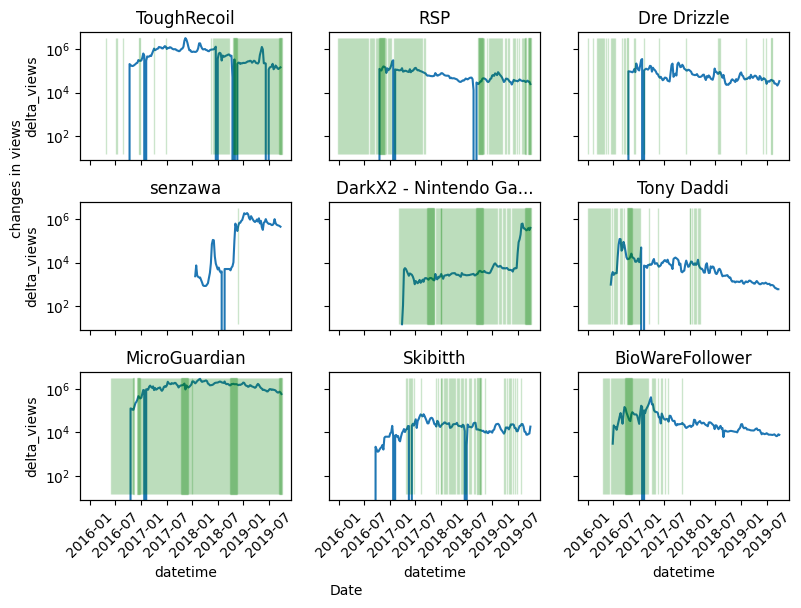

In [127]:
# plot graph of changes in views of the sample channel with collaboration data

fig, ax = plt.subplots(3,3,figsize= (8,6), sharey = True, sharex = True)

grouped = timeseries_collab_sample.groupby('channel').apply(lambda x: pd.DataFrame({
        'datetime': x['datetime'].values, 
        'delta_views': x['delta_views'].values
    }))

indexed_channels = list(set(grouped.index.get_level_values(0).values))

for i in range(9):

    sbplt = ax[i%3, math.floor(i/3)]

    # plot timeseries of changes in number of views a channel has
    sns.lineplot(x = 'datetime', y = 'delta_views', data = grouped.loc[indexed_channels[i]], ax=sbplt)
    sbplt.set_yscale('log')
    sbplt.set_title(channel_id_to_name_dict.get(indexed_channels[i]))
    sbplt.tick_params(axis='x', labelrotation=45)

    sbplt2 = sbplt.twinx()

    # plot collaboration binary timeline
    # plot green for collaboration in the week
    s1 = weekly_collaborators_sample[ (weekly_collaborators_sample['is_collaborating'] == 1) & (weekly_collaborators_sample['channel_id'] == indexed_channels[i])]
    inxval = matplotlib.dates.date2num(weekly_collaborators_sample[(weekly_collaborators_sample['is_collaborating'] == 1) & (weekly_collaborators_sample['channel_id'] == indexed_channels[i])]['Year-Week'].apply(lambda d: datetime.datetime.strptime(d + '-1', '%Y-%W-%w')))
    times= list(zip(inxval, np.ones(len(s1))))
    plt.yticks([])
    sbplt2.broken_barh(times, (0, 100), color="green", alpha = 0.2)
    
fig.tight_layout()

fig.text(0.4,0, "Date")
fig.text(0,0.6, "changes in views", rotation = 90)


Below, we plot both the views obtained by a random sample of 10 samples from the 100 most influential channels as found in the previous part with the times the channel engaged in collaborations with other channels. 

In [103]:
# random sample of 10 channels from the 100 most influential channels 
id_of_most_influential_channels = {'UC--7oyGW0N7fMf164-ZXljQ', 'UC--b720KocplK9zh0peruqg', 'UC--oOv_2PpzwK4WNsjG2UAw', 'UC--szL7ECbL2jmnOpx6BrNg', 'UC--vL4ZYLa0bi3TQcuwrhoA', 'UC-05oNebNywp5jy7iXZWZzA', 'UC-07j8SBVA5mHbiNWe2-jcw', 'UC-0Wg1wOUp-bRF1ZiC0dE8g', 'UC-0xJTkutOCoRoBi3YOkHRg'}

df_most_influential = df_timeseries[df_timeseries['channel'].isin(id_of_most_influential_channels)]

# obtain weekly collaboration data of sample channel
weekly_collab_most_influential = df_weekly_collaborators[df_weekly_collaborators['channel_id'].isin(id_of_most_influential_channels)]

# add binary column for presence of collaborations in a particular week
weekly_collab_most_influential['is_collaborating'] = weekly_collab_most_influential['collaborators_in_week'].apply(lambda x: 0 if x is None or pd.isna(x) else 1)

most_influential_grouped = df_most_influential.groupby('channel').apply(lambda x: pd.DataFrame({
        'datetime': x['datetime'].values, 
        'delta_views': x['delta_views'].values
    }))

indexed_influential_channels = list(set(most_influential_grouped.index.get_level_values(0).values))


/var/folders/1q/2jhpjh7924qd7d3drsy_79xw0000gn/T/ipykernel_5263/1853795176.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekly_collab_most_influential['is_collaborating'] = weekly_collab_most_influential['collaborators_in_week'].apply(lambda x: 0 if x is None or pd.isna(x) else 1)


Text(0, 0, 'changes in views of a sample of 10 channels among the 100 most influential channels')

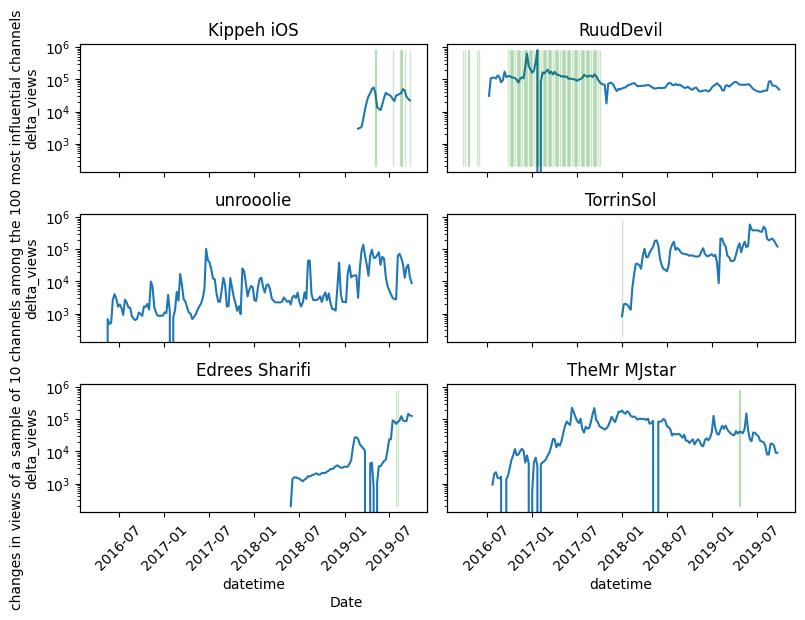

In [130]:
# plot graph of changes in views of the sample of 10 from the 100 most influenctial channels with collaboration data

fig, ax = plt.subplots(3,2,figsize= (8,6), sharey = True, sharex = True)

for i in range(6):

    sbplt = ax[i%3, math.floor(i/3)]

    # plot timeseries of changes in number of views a channel has
    sns.lineplot(x = 'datetime', y = 'delta_views', data = most_influential_grouped.loc[indexed_influential_channels[i]], ax=sbplt)
    sbplt.set_yscale('log')
    sbplt.set_title(channel_id_to_name_dict.get(indexed_influential_channels[i]))
    sbplt.tick_params(axis='x', labelrotation=45)

    sbplt2 = sbplt.twinx()

    # plot collaboration binary timeline
    # plot green for collaboration in the week
    s1 = weekly_collab_most_influential[ (weekly_collab_most_influential['is_collaborating'] == 1) & (weekly_collab_most_influential['channel_id'] == indexed_influential_channels[i])]
    inxval = matplotlib.dates.date2num(weekly_collab_most_influential[(weekly_collab_most_influential['is_collaborating'] == 1) & (weekly_collab_most_influential['channel_id'] == indexed_influential_channels[i])]['Year-Week'].apply(lambda d: datetime.datetime.strptime(d + '-1', '%Y-%W-%w')))
    times= list(zip(inxval, np.ones(len(s1))))
    plt.yticks([])
    sbplt2.broken_barh(times, (0, 100), color="green", alpha = 0.2)
    
fig.tight_layout()

fig.text(0.4,0, "Date")
fig.text(0,0, "changes in views of a sample of 10 channels among the 100 most influential channels", rotation = 90)


Next, we will compute the lifespan of the channels. We define a channel's death to be when the number of new views obtained in a month is less than 20% of the number of subscribers to the channel. 

In [83]:
# get lifespan of channels, a channel is considred dead if the views it gets in a month is 
# less than 20% of its number of subscribers. 
def diff_month(d1, d2): # d2 is always larger than d1
    d1 = datetime.datetime.strptime(d1, "%Y-%m")
    d2 = datetime.datetime.strptime(d2, "%Y-%m")
    d1_month = d1.month
    d2_month = d2.month
    diff_year = abs(d2.year - d1.year)
    return diff_year * 12 + (d2_month - d1_month)

def find_lifespan(grp):
    # lifespans = []
    # for i in grps.groups: 
    #     grp = grps.get_group(i)
    start_month = min(grp.index.get_level_values(1))
    end_month = min(grp[grp.delta_views < 0.2 * grp.subs].index.get_level_values(1)) if not grp[grp.delta_views < 0.2 * grp.subs].index.get_level_values(1).empty else max(grp.index.get_level_values(1))
    lifespan = diff_month(start_month, end_month)
    # lifespans.append(lifespan)
    return lifespan


In [84]:
df_timeseries['year_month'] = df_timeseries['datetime'].dt.strftime('%Y-%m')

channel_group = df_timeseries.dropna().groupby(['channel','year_month']).agg({'delta_views': "sum", 'subs': "max", 'views': "max", 'datetime': "max"})

channel_group = channel_group.dropna().drop(channel_group[channel_group.subs == 0].index).drop(channel_group[channel_group.views == 0].index).sort_values('datetime', ascending=True)

channel_indexes = list(set(channel_group.index.get_level_values(0).values))


In [85]:
channel_lifespan = channel_group.groupby('channel').apply(lambda grp: find_lifespan(grp))

In [86]:
# correlation between whether a channel has collaborated and its lifespan

def count_collabs(series): 
    count = 0
    for x in series: 
        count += 0 if x is None else 1
    return count

df_weekly_collaborators['no_of_collabs'] = df_weekly_collaborators['collaborators_in_week'].apply(lambda x: 0 if x is None or pd.isna(x) else count_collabs(x))
df_grouped_collab = df_weekly_collaborators.groupby('channel_id', as_index=False).agg({ 'no_of_collabs' : "sum"})

# merge a table of channels and its corresponding lifespan with table of channels and collab
df_collaborators_lifespan = df_grouped_collab.merge(pd.DataFrame(data={"lifespan": channel_lifespan.values, "channel_id": channel_lifespan.index}), how='inner', on='channel_id').dropna(subset='no_of_collabs')

# display(df_collaborators_lifespan.columns)

df_w_collab = df_collaborators_lifespan.merge(df_channels.rename(columns={'channel' : 'channel_id'}), how='inner', on='channel_id').reset_index(drop=True)

df_w_collab_gaming = df_w_collab[df_w_collab['category_cc']=='Gaming']

Text(0, 0.5, 'Number of channels')

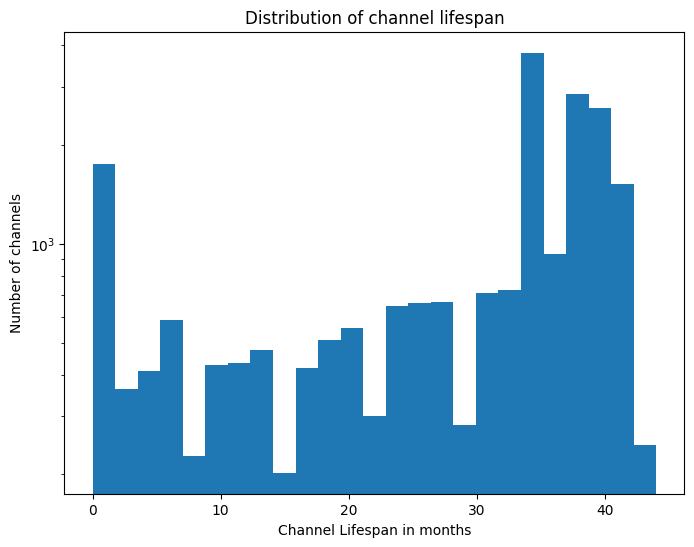

In [87]:
fig, ax = plt.subplots(figsize = (8,6))

sbplt = ax
sbplt.hist(channel_lifespan, bins = 25)
ax.set_yscale('log')
sbplt.set_title("Distribution of channel lifespan")
plt.xlabel("Channel Lifespan in months")
plt.ylabel("Number of channels")

In [88]:
# correlation between whether a channel has collaborated and its lifespan

def count_collabs(series): 
    count = 0
    for x in series: 
        count += 0 if x is None else 1
    return count

df_weekly_collaborators['no_of_collabs'] = df_weekly_collaborators['collaborators_in_week'].apply(lambda x: 0 if x is None or pd.isna(x) else count_collabs(x))
df_grouped_collab = df_weekly_collaborators.groupby('channel_id', as_index=False).agg({ 'no_of_collabs' : "sum"})

# merge a table of channels and its corresponding lifespan with table of channels and collab
df_collaborators_lifespan = df_grouped_collab.merge(pd.DataFrame(data={"lifespan": channel_lifespan.values, "channel_id": channel_lifespan.index}), how='inner', on='channel_id').dropna(subset='no_of_collabs')

df_w_collab = df_collaborators_lifespan.merge(df_channels.rename(columns={'channel' : 'channel_id'}), how='inner', on='channel_id').reset_index(drop=True)

df_w_collab_gaming = df_w_collab[df_w_collab['category_cc']=='Gaming']

Next, we will run some regressional analysis on the dataset. 

We will mainly explore the following relationships: 
1. the correlation between the lifespan of a channel and the number of collaborations it engages in
2. the correlation between the number of subscribers a channel has and the number of collaborations it engages in

In [89]:
mod_lifespan_collab = smf.ols(formula='lifespan ~ no_of_collabs', data=df_w_collab_gaming)
res_lifespan_collab = mod_lifespan_collab.fit()

print(res_lifespan_collab.summary())

                            OLS Regression Results                            
Dep. Variable:               lifespan   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     110.1
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           1.06e-25
Time:                        16:32:39   Log-Likelihood:                -78583.
No. Observations:               19629   AIC:                         1.572e+05
Df Residuals:                   19627   BIC:                         1.572e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        27.4335      0.097    282.004

A possible reason why the lifespan of a channel may increase with collaboration may be is because of a third confounding factor: the number of videos uploaded. 

We will thus model the lifespan of a channel with the number of videos uploaded as an interactive predictor. 

In [ ]:
mod_lifespan_collab_vid = smf.ols(formula='lifespan ~ no_of_collabs * videos_cc', data=df_w_collab_gaming)
res_lifespan_collab_vid = mod_lifespan_collab_vid.fit()

print(res_lifespan_collab_vid.summary())

                            OLS Regression Results                            
Dep. Variable:               lifespan   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     229.6
Date:                Fri, 22 Dec 2023   Prob (F-statistic):          2.01e-146
Time:                        16:18:24   Log-Likelihood:                -78300.
No. Observations:               19629   AIC:                         1.566e+05
Df Residuals:                   19625   BIC:                         1.566e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

Next we will model the relationship between number of collaboration and views of channels. 

Next we will model the relationship between number of collaboration and numebr of subscribers of channels. 

In [ ]:
mod_lifespan_collab_vid = smf.ols(formula='subscribers_cc ~ no_of_collabs', data=df_w_collab_gaming)
res_lifespan_collab_vid = mod_lifespan_collab_vid.fit()

print(res_lifespan_collab_vid.summary())

                            OLS Regression Results                            
Dep. Variable:         subscribers_cc   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     162.9
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           3.69e-37
Time:                        16:18:24   Log-Likelihood:            -3.0017e+05
No. Observations:               19629   AIC:                         6.003e+05
Df Residuals:                   19627   BIC:                         6.004e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.806e+05   7775.263     23.223